In [16]:
from vqvae import VQVAE
from utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import functional as F

import numpy as np

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:

# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


True
cuda:0


In [18]:

# 1. Load and Preprocess the Dataset
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    # transforms.Normalize((0.5,), (0.5,)) # Normalize the images to [-1, 1]
])

# Download and load the Fashion-MNIST training and test dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

TrainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Class labels for reference
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



-------
### Re-fit 

In [19]:
new_K =  64 # size of the CodeBook
K = 128
D =  32 # dimension of each embedding vector
in_channels = 1 # gray scale image  = 1 color channel
downsampling_factor = 4 # two stages of dwonsampling the image (28x28) --> (7x7)

In [22]:
model_path = 'saved_models/model_101.pth'

model = VQVAE(in_channels, D, K)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_966500/1448835256.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


In [23]:
# saving the previous model encoder and decoder : 

# Load the saved model checkpoint
checkpoint = torch.load(model_path)
# Filter the encoder parameters
encoder_state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith('encoder.')}
# Filter the decoder parameters
decoder_state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith('decoder.')}

/tmp/ipykernel_966500/202680754.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [26]:
# we are going to pass through the whole dataset, which results on 

latent_vectors = []

# Process the dataset
with torch.no_grad():  # No need to track gradients
    for (batch,_) in TrainLoader:
        # Pass the batch through the encoder
        encoded = model.encode(batch.float().to(device))[0]  # Output shape: (batch_size, 32, 32, 32)
        
        # Flatten the encoded output to (batch_size, 32*32)
        encoded_flat = encoded.view(encoded.size(0), D, -1).permute(0, 2, 1)  # Shape: (batch_size, 1024, D)
        
        # Now flatten across the batch and spatial dimensions to (batch_size * 1024, D)
        encoded_flat = encoded_flat.reshape(-1, D)
        
        # Convert the tensor to NumPy and store it
        latent_vectors.append(encoded_flat.cpu().numpy())

# Concatenate all the latent vectors into a single NumPy array
latent_vectors = np.concatenate(latent_vectors, axis=0)  # Shape: (size_of_dataset, 32*32)

# # Optionally, save the latent vectors to disk
# np.save('latent_vectors.npy', latent_vectors)

In [27]:
from sklearn.cluster import kmeans_plusplus

# Calculate seeds from k-means++
centers_init, indices = kmeans_plusplus(latent_vectors, n_clusters= new_K)

In [31]:

# let's take just P samples from the whole distribution : 
P = 10000

total_vectors = latent_vectors.shape[0]

# Randomly sample N unique indices from the range of total_vectors
sample_indices = np.random.choice(total_vectors, size=P, replace=False)

# Extract the corresponding vectors
latent_vectors_red = latent_vectors[sample_indices, :]  # Shape: (N, 64)

In [32]:
# codebook = model.vq_layer.embedding.weight.data.cpu().detach()

In [33]:
#Projection using UMAP

import umap
import numpy as np

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
d2_latent_vectors_red = reducer.fit_transform(latent_vectors_red)
d2_centers_init       = reducer.transform(centers_init)
# d2_codebook_vecs      = reducer.transform(np.array(codebook))

/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


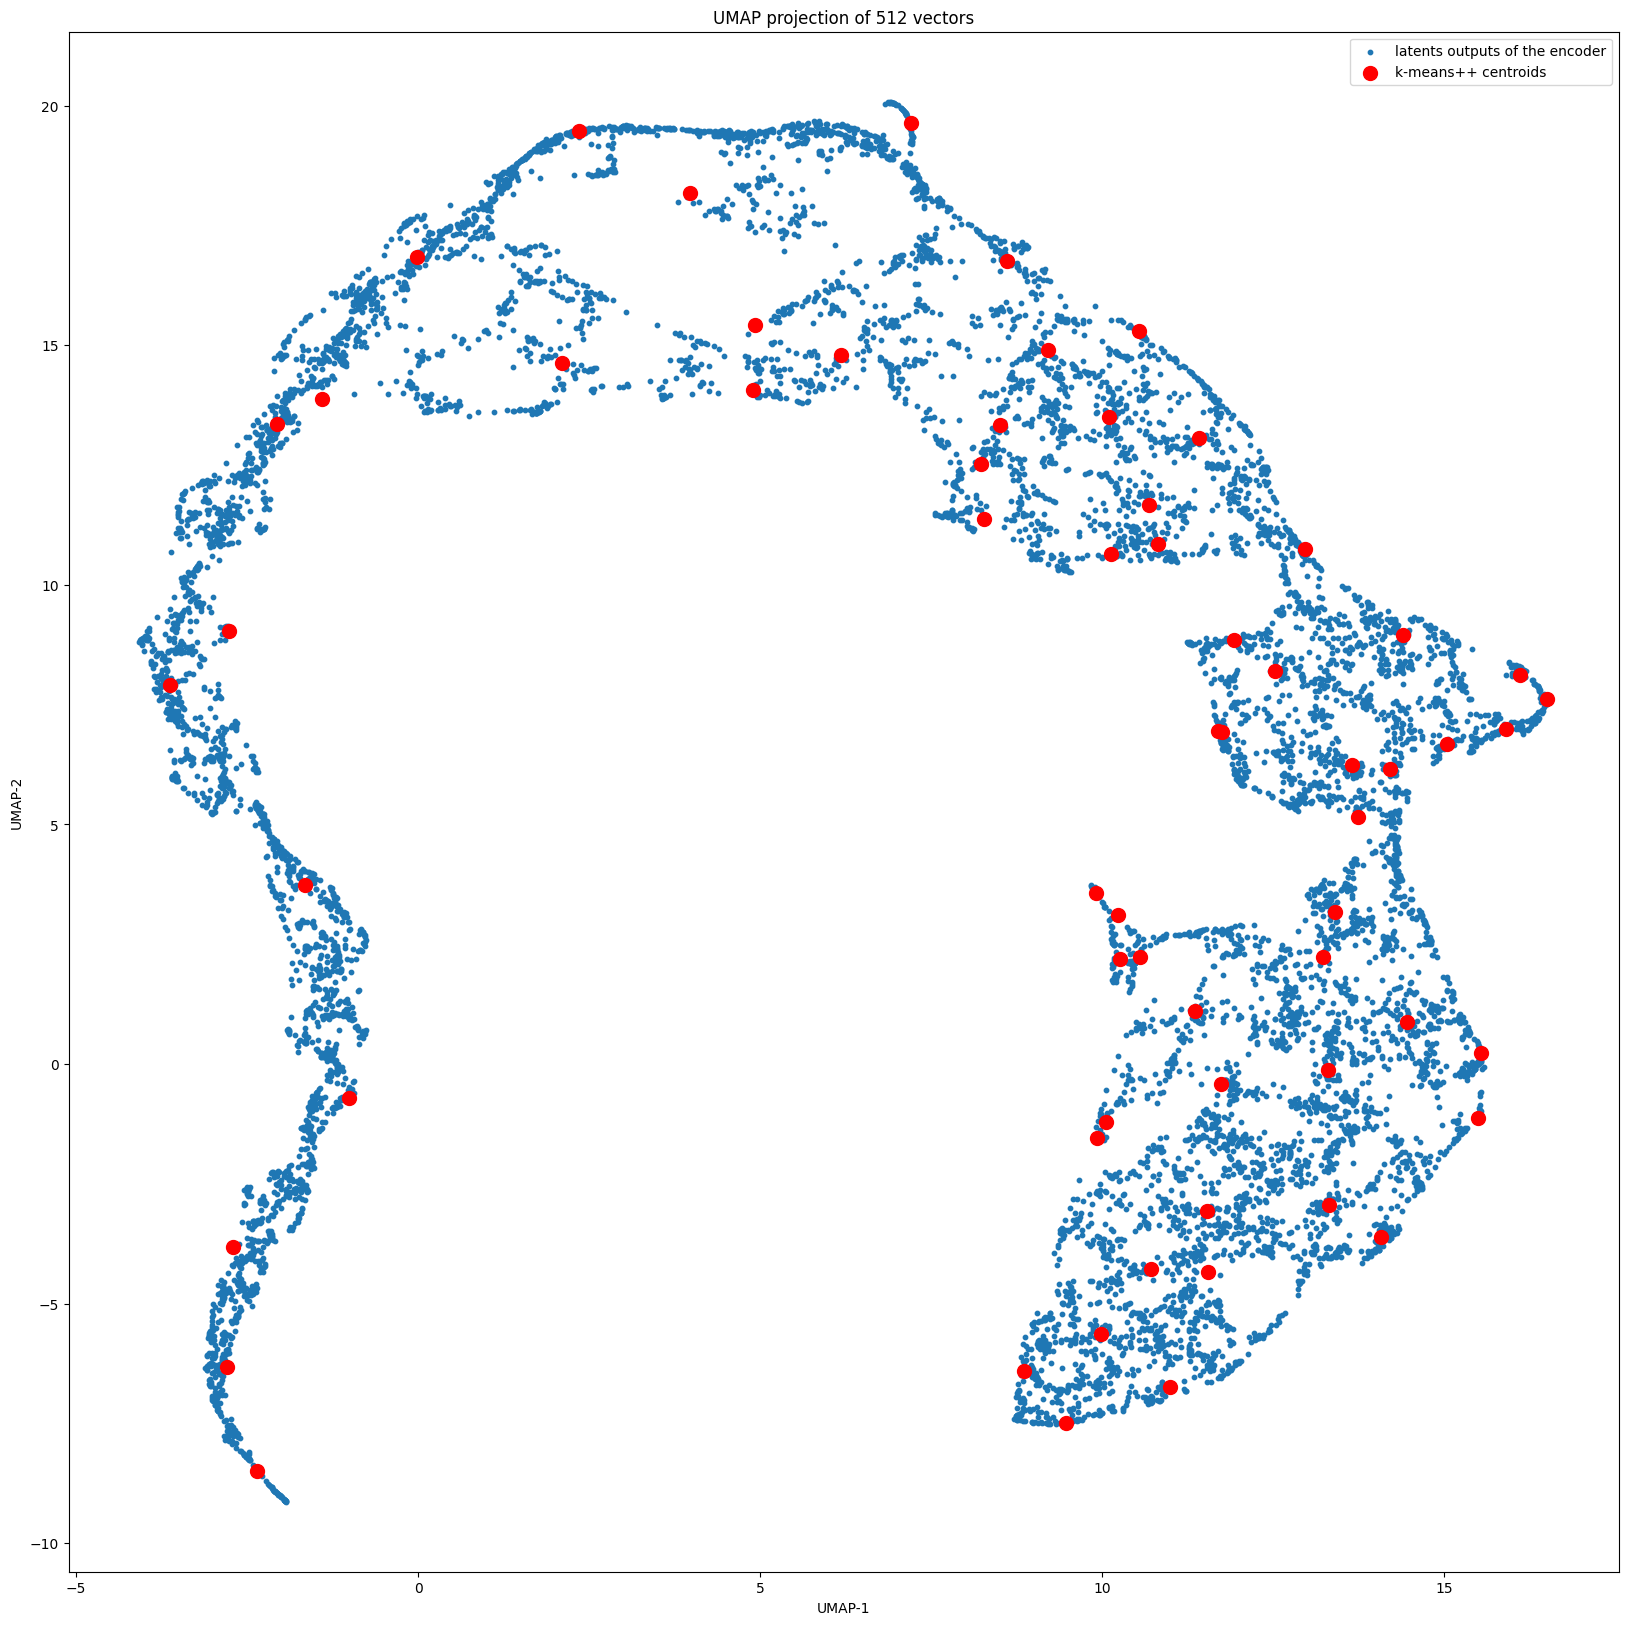

In [40]:

plt.figure(figsize=(20,20))
# Plot the results
plt.scatter(d2_latent_vectors_red[:, 0], d2_latent_vectors_red[:, 1], s = 10,label= 'latents outputs of the encoder')
plt.scatter(d2_centers_init[:, 0], d2_centers_init[:, 1], s = 100, c='red', label = 'k-means++ centroids')
# plt.scatter(d2_codebook_vecs[:,0], d2_codebook_vecs[:,1], s=200, c = 'red', label = 'codeBook codes')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

plt.legend()
plt.show()

In [56]:
new_codebook = torch.from_numpy(centers_init)

ACDC_VQVAE = VQVAE(in_channels, D, new_K, embedding = new_codebook)
model = ACDC_VQVAE.to(device)

In [57]:
# Load the encoder and decoder weights into the new model
# Remove the 'encoder.' prefix from all keys in encoder_state_dict
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_state_dict.items()}
model.encoder.load_state_dict(encoder_state_dict)

# Remove the 'encoder.' prefix from all keys in encoder_state_dict
decoder_state_dict = {k.replace('decoder.', ''): v for k, v in decoder_state_dict.items()}
model.decoder.load_state_dict(decoder_state_dict)

<All keys matched successfully>

In [63]:

lr = 5e-4
epochs = 5
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_path = 'saved_models/model_Refit.pth'

In [60]:

# visualisation batch, to track th eperformance of the model
vis_batch, classes = next(iter(TestLoader))

In [64]:
model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs, classes) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    # #track output precision progression every 10 epoch:
    # if (epoch%5 == 0 and epoch<50):
    #     output, _, _, _ = model( vis_batch.float() )
    #     recons_evolution.append(output)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/1875 [00:00<?, ?batch/s]

100%|██████████| 1875/1875 [00:22<00:00, 83.38batch/s, loss=0.00978]


Epoch 0: Train Loss: 0.0103


100%|██████████| 1875/1875 [00:22<00:00, 82.67batch/s, loss=0.011]  


Epoch 1: Train Loss: 0.0101
Training complete.


In [1]:
# save_path = model_name
# save_model(save_path, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

---

In [67]:
hist = codebook_hist_testset(model, TestLoader)

 ONLY 64 OF CODES WERE USED FROM 64, WHICH MAKE 100.0 % OF CODES FROM THE CODE-BOOK


Text(0.5, 1.0, 'Histogram of used codes during one pass through test-set')

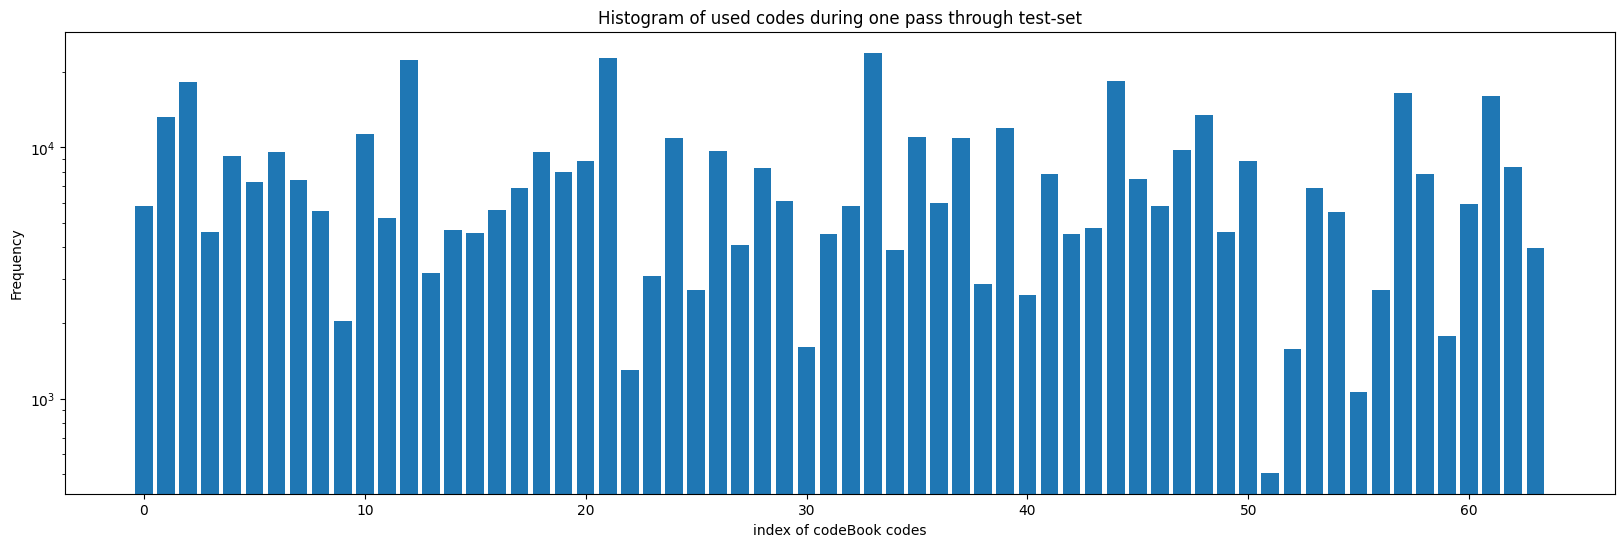

In [68]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

plt.xlabel('index of codeBook codes')        # Label for the x-axis
plt.ylabel('Frequency')    # Label for the y-axis
plt.title('Histogram of used codes during one pass through test-set')  # Title

### Conclusion:

>> We observe that we could hit a 100% usage of the codebook and reducing by half its size while maintaining the same perfromances of the model.

>> now we can say that we have a ready vocabulary to learn an autoregressive model, it could be an LLM with the codeBook as a Vocabulary.
